In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.lines import Line2D # Required for creating custom legend elements
# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Statistical libraries
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import glob


class AdvancedEnergyAnalysis:
    """
    Advanced analysis class implementing a streamlined four-stage progressive modeling approach.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = {}
        self.models = {}
        self.data = None
        self.feature_names = None
        self.target_names = None
        
        # Equipment repair times in hours
        self.repair_time_hours = {
            'WT': 336,   # Wind Turbine: 336 hours
            'PV': 96,    # PV: 96 hours  
            'WEC': 336,  # WEC: 336 hours
            'LNG': 96    # LNG/CHP: 96 hours
        }
        
        # Convert to 3-hour time steps for simulation
        self.repair_time_steps = {
            device: hours // 3 for device, hours in self.repair_time_hours.items()
        }
        
        # Set Nature journal plotting style
        plt.style.use('default')
        plt.rcParams.update({
            'font.family': 'Arial',
            'font.size': 10,
            'axes.labelsize': 10,
            'axes.titlesize': 11,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'legend.fontsize': 9,
            'figure.dpi': 300,
            'savefig.dpi': 300,
            'axes.linewidth': 0.8,
            'grid.linewidth': 0.4,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'xtick.direction': 'out',
            'ytick.direction': 'out',
            'axes.edgecolor': '#333333',
            'text.color': '#333333',
            'axes.labelcolor': '#333333',
            'xtick.color': '#333333',
            'ytick.color': '#333333'
        })
    
    def failure_probability_wt(self, ve):
        """Wind Turbine failure probability based on wind speed"""
        if ve < 30:
            return 0
        elif ve >= 60:
            return 1.0
        else:
            return (ve - 30) / (60 - 30)
    
    def failure_probability_pv(self, ve):
        """PV failure probability based on wind speed"""
        if ve < 40:
            return 0
        elif ve >= 80:
            return 1.0
        else:
            return (ve - 40) / (80 - 40)
    
    def failure_probability_wec(self, ve):
        """WEC failure probability based on wind speed (simplified)"""
        if ve < 35:
            return 0
        elif ve >= 70:
            return 1.0
        else:
            return (ve - 35) / (70 - 35)
    
    def device_state_simulation(self, wind_speeds):
        """
        Simulate device states over time considering failure and repair dynamics.
        """
        time_horizon = len(wind_speeds)
        device_generate = ['WT', 'PV', 'WEC', 'LNG']
        device_states_df = pd.DataFrame(index=range(time_horizon), columns=device_generate, dtype=int)
        
        device_states = {device: 1 for device in device_generate}  # 1 = working, 0 = failed
        time_in_states = {device: 0 for device in device_generate}
        
        np.random.seed(self.random_state)
        
        for t in range(time_horizon):
            V = wind_speeds.iloc[t] if hasattr(wind_speeds, 'iloc') else wind_speeds[t]
            
            for device in device_generate:
                if device == 'LNG':
                    # LNG fails when wind speed > 20 m/s
                    if V > 20:
                        device_states[device] = 0
                        time_in_states[device] = 0
                    else:
                        device_states[device] = 1
                else:
                    # Check for new failures in working equipment
                    if device_states[device] == 1:
                        if device == 'WT':
                            failure_prob = self.failure_probability_wt(V)
                        elif device == 'PV':
                            failure_prob = self.failure_probability_pv(V)
                        elif device == 'WEC':
                            failure_prob = self.failure_probability_wec(V)
                        else:
                            failure_prob = 0
                        
                        if np.random.random() < failure_prob:
                            device_states[device] = 0
                            time_in_states[device] = 0
                
                    # Handle repair for failed equipment
                    if device_states[device] == 0:
                        # Repair is only possible when wind speed is suitable (≤ 20 m/s)
                        if V <= 20:
                            time_in_states[device] += 1
                        
                        # Check if repair is complete
                        if time_in_states[device] >= self.repair_time_steps[device]:
                            device_states[device] = 1
                            time_in_states[device] = 0
                
                # High wind speed forces all equipment to stop
                if V > 20:
                    device_states[device] = 0
                
                device_states_df.at[t, device] = device_states[device]
        
        return device_states_df
    
    def extract_failure_features(self, scenario_df):
        """
        Extract comprehensive failure features from equipment failure simulation.
        Returns all durations in hours.
        """
        features = {}
        devices = scenario_df.columns
        time_step_hours = 3
        
        for device in devices:
            downtime = 1 - scenario_df[device]
            total_downtime_steps = downtime.sum()
            features[f'total_downtime_hours_{device}'] = total_downtime_steps * time_step_hours
            
            consecutive_groups = (downtime != downtime.shift()).cumsum()
            consecutive_downtime = downtime.groupby(consecutive_groups).sum()
            max_consecutive_steps = consecutive_downtime.max() if not consecutive_downtime.empty else 0
            features[f'max_consecutive_downtime_hours_{device}'] = max_consecutive_steps * time_step_hours

        # Use the maximum consecutive downtime across all devices as a key system reliability feature
        max_system_downtime_hours = max(features.get(f'max_consecutive_downtime_hours_{d}', 0) for d in devices)
        features['max_failure_duration_hours'] = max_system_downtime_hours
        
        return features
    
    def calculate_real_data(self):
        """
        Calculate comprehensive island energy system data for both 2020 and 2050 scenarios.
        """
        print("Loading and preparing island energy system data for 2020 and 2050 scenarios...")
        
        islands_df = pd.read_csv('../result/island_data_origin.csv')
        results_data = []
        
        scenarios = {
            2020: {'output_dir': '../result/output_2020', 'cost_summary_file': '../result/island_cost_summary_2020.csv'},
            2050: {'output_dir': '../result/output_2050', 'cost_summary_file': '../result/island_cost_summary_2050.csv'}
        }
        
        windspeed_dir = '../result/island_windspeed_data'
        demand_dir = '../demand_get/data/get1'
        
        for year, config in scenarios.items():
            print(f"Processing {year} scenario...")
            cost_summary_df = pd.read_csv(config['cost_summary_file'])
            
            for _, island in islands_df.iterrows():
                lat, lon = island['Lat'], island['Long']
                
                windspeed_file = os.path.join(windspeed_dir, f"{lat}_{lon}_{year}_windspeed.csv")
                output_file = os.path.join(config['output_dir'], f"{lat}_{lon}_results.csv")
                demand_file = os.path.join(demand_dir, f"demand_{lat}_{lon}.csv")
                
                cost_data = cost_summary_df[(cost_summary_df['lat'] == lat) & (cost_summary_df['lon'] == lon)]

                if os.path.exists(windspeed_file) and os.path.exists(output_file) and not cost_data.empty:
                    try:
                        wind_df = pd.read_csv(windspeed_file)
                        wind_col = f'Wind_Speed_{year}' if f'Wind_Speed_{year}' in wind_df.columns else wind_df.columns[0]
                        wind_speeds = wind_df[wind_col]
                        pdi = (wind_speeds ** 3).sum()
                        
                        device_states_df = self.device_state_simulation(wind_speeds)
                        failure_features = self.extract_failure_features(device_states_df)
                        max_failure_duration = failure_features['max_failure_duration_hours']
                        
                        output_df = pd.read_csv(output_file)
                        e_wt = output_df.get('WT', pd.Series(0)).sum()
                        e_pv = output_df.get('PV', pd.Series(0)).sum()
                        e_wec = output_df.get('WEC', pd.Series(0)).sum()
                        e_chp = output_df.get('CHP_electric_output', pd.Series(0)).sum()
                        
                        renewable_energy = e_wt + e_pv + e_wec
                        total_energy = renewable_energy + e_chp
                        renewable_penetration = renewable_energy / total_energy if total_energy > 0 else 0
                        
                        cost_data_row = cost_data.iloc[0]
                        
                        results_data.append({
                            'ID': island['ID'], 'Long': lon, 'Lat': lat, 'Country': island['Country'],
                            'Island': island['Island'], 'Population': island['pop'], 'Year': year,
                            'PDI': pdi,
                            'Max_Failure_Duration_Hours': max_failure_duration,
                            'Renewable_Penetration': renewable_penetration,
                            'Renewable_Cost': cost_data_row.get('renewable_cost_per_capita', 0),
                            'Total_Storage_Investment': cost_data_row.get('storage_cost_per_capita', 0),
                            'LNG_Cost': cost_data_row.get('lng_cost_per_capita', 0)
                        })
                    except Exception as e:
                        # print(f"Skipping island {lat},{lon} for {year} due to error: {e}")
                        continue
        
        analysis_df = pd.DataFrame(results_data)
        if analysis_df.empty:
            print("❌ Error: No data available for analysis")
            return None
        
        self.data = analysis_df.dropna()
        print(f"Data loaded successfully: {len(self.data)} records")
        
        self.feature_names = ['PDI', 'Max_Failure_Duration_Hours']
        self.target_names = ['Renewable_Cost', 'Total_Storage_Investment', 'LNG_Cost']
        
        return self.data

    def apply_data_cleaning(self, strategy='moderate'):
        """
        Apply data cleaning strategy.
        """
        if self.data is None:
            print("❌ Error: No data loaded")
            return None
        
        print(f"\n🔧 Applying {strategy.upper()} data cleaning strategy...")
        df_cleaned = self.data.copy()
        original_count = len(df_cleaned)
        
        # Remove cases where all investment costs are zero, as they represent unoptimized scenarios
        mask_all_zero = (
            (df_cleaned['Renewable_Cost'] == 0) & 
            (df_cleaned['Total_Storage_Investment'] == 0) & 
            (df_cleaned['LNG_Cost'] == 0)
        )
        df_cleaned = df_cleaned[~mask_all_zero]
        
        final_count = len(df_cleaned)
        removed_count = original_count - final_count
        print(f"  • Original records: {original_count}")
        print(f"  • Final records: {final_count} (Removed: {removed_count}, {removed_count/original_count:.1%})")
        
        self.data = df_cleaned
        return df_cleaned

    def stage1_correlation_analysis(self):
        """
        Stage 1: Correlation Analysis - Global view with heatmap and collinearity checks.
        """
        print("\n" + "="*80)
        print("🎯 STAGE 1: CORRELATION ANALYSIS")
        print("="*80)
        
        all_vars = self.feature_names + self.target_names
        corr_matrix = self.data[all_vars].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
        plt.title('Full Correlation Matrix', fontsize=14, fontweight='bold')
        plt.show()
        
        print("\n📊 Correlation Analysis Results:")
        # VIF Analysis for collinearity
        X = self.data[self.feature_names].values
        vif_data = pd.DataFrame()
        vif_data["Feature"] = self.feature_names
        vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(len(self.feature_names))]
        
        print("  VIF Values (>5 suggests potential multicollinearity):")
        for _, row in vif_data.iterrows():
            status = "⚠️" if row["VIF"] > 5 else "✅"
            print(f"    {status} {row['Feature']}: {row['VIF']:.2f}")
            
        self.results['stage1'] = {'correlation_matrix': corr_matrix, 'vif': vif_data}

    def stage2_linear_modeling(self):
        """
        Stage 2: Linear Modeling and Performance Evaluation.
        """
        print("\n" + "="*80)
        print("📏 STAGE 2: LINEAR MODELING")
        print("="*80)
        
        linear_results = {}
        X = self.data[self.feature_names]
        
        for target in self.target_names:
            print(f"\n📊 Analyzing {target.replace('_', ' ')}:")
            y = self.data[target]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.random_state)
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model = LinearRegression()
            model.fit(X_train_scaled, y_train)
            
            y_pred_test = model.predict(X_test_scaled)
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            
            X_scaled_full = scaler.transform(X)
            cv_scores = cross_val_score(model, X_scaled_full, y, cv=5, scoring='r2')
            
            print(f"  • Test R²: {test_r2:.4f}")
            print(f"  • Test RMSE: {test_rmse:.2f}")
            print(f"  • CV R² (mean±std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            
            feature_importance = np.abs(model.coef_) / np.sum(np.abs(model.coef_))
            
            linear_results[target] = {
                'model': model, 'scaler': scaler, 'test_r2': test_r2,
                'y_test': y_test, 'y_pred_test': y_pred_test,
                'coefficients': model.coef_, 'feature_importance': feature_importance
            }
        
        self.models['linear'] = linear_results
        self.results['stage2'] = linear_results
        self.visualize_linear_results()
        
    def visualize_linear_results(self):
        """
        Visualize linear regression results including feature importance and prediction accuracy.
        """
        fig, axes = plt.subplots(2, len(self.target_names), figsize=(18, 10))
        fig.suptitle('Stage 2: Linear Regression Analysis Results', fontsize=18, fontweight='bold')
        colors = ['#2E8B57', '#4169E1', '#DC143C']
        
        for i, target in enumerate(self.target_names):
            results = self.results['stage2'][target]
            
            # Feature Importance
            ax1 = axes[0, i]
            importance_df = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': results['feature_importance']
            }).sort_values('Importance', ascending=True)
            ax1.barh(importance_df['Feature'], importance_df['Importance'], color=colors[i], alpha=0.7)
            ax1.set_xlabel('Normalized Importance')
            ax1.set_title(f'{target.replace("_", " ")}\nFeature Importance')
            
            # Predicted vs Actual
            ax2 = axes[1, i]
            ax2.scatter(results['y_test'], results['y_pred_test'], alpha=0.7, color=colors[i], edgecolors='w')
            min_val = min(results['y_test'].min(), results['y_pred_test'].min())
            max_val = max(results['y_test'].max(), results['y_pred_test'].max())
            ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
            ax2.set_xlabel('Actual Values')
            ax2.set_ylabel('Predicted Values')
            ax2.set_title(f'R² = {results["test_r2"]:.3f}')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def stage3_deep_interpretation(self):
        """
        Stage 3: Linear Model Interpretation - Coefficient analysis.
        """
        print("\n" + "="*80)
        print("🔬 STAGE 3: LINEAR MODEL INTERPRETATION")
        print("="*80)
        
        for target in self.target_names:
            print(f"\n🎯 Linear model interpretation for {target.replace('_', ' ')}:")
            results = self.results['stage2'][target]
            model = results['model']
            
            coef_df = pd.DataFrame({
                'Feature': self.feature_names,
                'Coefficient': model.coef_
            }).sort_values('Coefficient', ascending=False)
            
            print("  📈 Standardized Coefficients:")
            for _, row in coef_df.iterrows():
                print(f"    {row['Feature']:<30}: {row['Coefficient']:.4f}")
        
            self.visualize_coefficients(coef_df, target)

    def visualize_coefficients(self, coef_df, target):
        """Visualize coefficients for a single target model."""
        plt.figure(figsize=(8, 4))
        colors = ['red' if x < 0 else 'blue' for x in coef_df['Coefficient']]
        plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
        plt.xlabel('Standardized Coefficient Value')
        plt.title(f'Coefficient Analysis for {target.replace("_", " ")}')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

    def stage4_advanced_correlation_analysis(self):
        """
        Stage 4: Advanced Correlation Analysis using a sliding window to
        investigate how disaster-cost relationships change with renewable penetration.
        """
        print("\n" + "="*80)
        print("🧪 STAGE 4: ADVANCED CORRELATION ANALYSIS (SLIDING WINDOW)")
        print("="*80)
        
        self.plot_multi_target_correlation_trends()


    def generate_comprehensive_report(self):
        """
        Generate a comprehensive analysis report summarizing all stages.
        """
        print("\n" + "="*80)
        print("📋 COMPREHENSIVE ANALYSIS REPORT")
        print("="*80)
        
        print("\n🎯 SUMMARY OF FINDINGS:")
        print("-" * 40)
        
        print("\n📊 LINEAR REGRESSION PERFORMANCE (Test R²):")
        for target in self.target_names:
            r2 = self.results['stage2'][target]['test_r2']
            print(f"  • {target.replace('_', ' '):<25}: R² = {r2:.4f}")
        
        print("\n🔍 KEY FEATURE INSIGHTS (Normalized Importance):")
        for target in self.target_names:
            print(f"\n  {target.replace('_', ' ').upper()}:")
            results = self.results['stage2'][target]
            importance_df = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': results['feature_importance']
            }).sort_values('Importance', ascending=False)
            for _, row in importance_df.iterrows():
                print(f"    - {row['Feature']:<30}: {row['Importance']:.3f}")
        
        print("\n📈 ADVANCED CORRELATION INSIGHTS:")
        print("  Sliding window analysis reveals how the correlation between disaster")
        print("  indicators and system costs changes across different levels of")
        print("  renewable energy penetration, highlighting complex interactions.")
        
        print("\n" + "="*80)
        print("✅ COMPREHENSIVE ANALYSIS COMPLETED!")
        print("="*80)
    
    def plot_multi_target_correlation_trends(self):
        """
        Plot correlation trends for all target variables in a single plot,
        with specified colors for different cost types.
        """
        # Save original font and set to Arial for this plot only
        original_font = plt.rcParams['font.family']
        plt.rcParams['font.family'] = 'Arial'

        try:
            renewable_col = 'Renewable_Penetration'
            # Only use PDI for the correlation analysis
            disaster_features = ['PDI']
            data = self.data
            
            window_size = 0.2  # 窗口大小参数，控制滑动窗口的宽度
            step_size = 0.05   # 步长参数，控制窗口移动的间隔
            renewable_min, renewable_max = data[renewable_col].min(), 1
            print(f'renewable_min:{renewable_min}, renewable_max:{renewable_max}')
            window_centers = np.arange(renewable_min + window_size / 2, renewable_max - window_size / 2, step_size)
            
            # Create a single plot for all cost types
            fig, ax = plt.subplots(1, 1, figsize=(8, 3),dpi=300)
            
            # Specified colors for different cost types
            cost_colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # 三种成本类型的指定颜色
            
            # Cost type labels mapping
            cost_labels = {
                'Renewable_Cost': 'Renewable Generation Cost',
                'Total_Storage_Investment': 'Energy Storage System Cost', 
                'LNG_Cost': 'LNG Cost'
            }
            
            # Plot correlation trends for each cost type
            for target_idx, target in enumerate(self.target_names):
                for feature_idx, feature in enumerate(disaster_features):
                    correlations, p_values, valid_centers = [], [], []
                    for center in window_centers:
                        window_mask = (data[renewable_col] >= center - window_size / 2) & (data[renewable_col] <= center + window_size / 2)
                        window_data = data[window_mask]
                        if len(window_data) > 15:  # 最小样本量参数，确保统计结果的可靠性
                            corr, p_value = pearsonr(window_data[feature], window_data[target])
                            correlations.append(corr)
                            p_values.append(p_value)
                            valid_centers.append(center)
                    
                    if len(correlations) > 2:
                        # Use specified colors for each cost type
                        color = cost_colors[target_idx]
                        cost_label = cost_labels[target]
                        
                        # Plot correlation trend line
                        ax.plot(valid_centers, correlations, '-', color=color, lw=2, alpha=0.9, label=cost_label)
                        ax.scatter(valid_centers, correlations, color=color, s=25, alpha=0.7, edgecolors='white', lw=0.5, zorder=3)
                        
                        # Add squares for significant points
                        sig_centers = [c for c, p in zip(valid_centers, p_values) if p < 0.05]
                        sig_corrs = [corr for corr, p in zip(correlations, p_values) if p < 0.05]
                        if sig_centers:
                            ax.scatter(sig_centers, sig_corrs, s=35, color=color, marker='s', edgecolors='black', lw=0.8, zorder=4)

            # Set plot properties
            ax.axhline(y=0, color='#666666', ls='-', alpha=0.4, lw=0.8)  # 零线参考
            ax.set_ylabel('Correlation coefficient', fontsize=16)  # 相关系数标签
            ax.set_xlabel('Renewable energy penetration', fontsize=16)  # 可再生能源渗透率标签
            ax.set_ylim(-1, 1)  # Y轴范围参数
            ax.set_yticks(np.arange(-1.0, 1.1, 0.2))  # Y轴刻度参数
            ax.grid(False)  # 网格线参数
            ax.tick_params(axis='both', which='major', labelsize=16)
            # Set title
            # ax.set_title('Disaster impacts on energy system costs', fontsize=16, fontweight='bold')
            
            # Add legend for cost types
            ax.legend(loc='lower right', frameon=False, fontsize=12)
            
            plt.tight_layout()
            plt.show()

        finally:
            # Restore the original font settings
            plt.rcParams['font.family'] = original_font

Advanced Energy System Investment Analysis
Using streamlined progressive modeling approach:
  1. Correlation Analysis (Global View)
  2. Linear Modeling (Performance Evaluation)
  3. Deep Interpretation (Coefficient Analysis)
  4. Advanced Correlation (Sliding Window Analysis)

Loading and preparing island energy system data for 2020 and 2050 scenarios...
Processing 2020 scenario...
Processing 2050 scenario...
Data loaded successfully: 3450 records

🔧 Applying MODERATE data cleaning strategy...
  • Original records: 3450
  • Final records: 3450 (Removed: 0, 0.0%)

🎯 STAGE 1: CORRELATION ANALYSIS


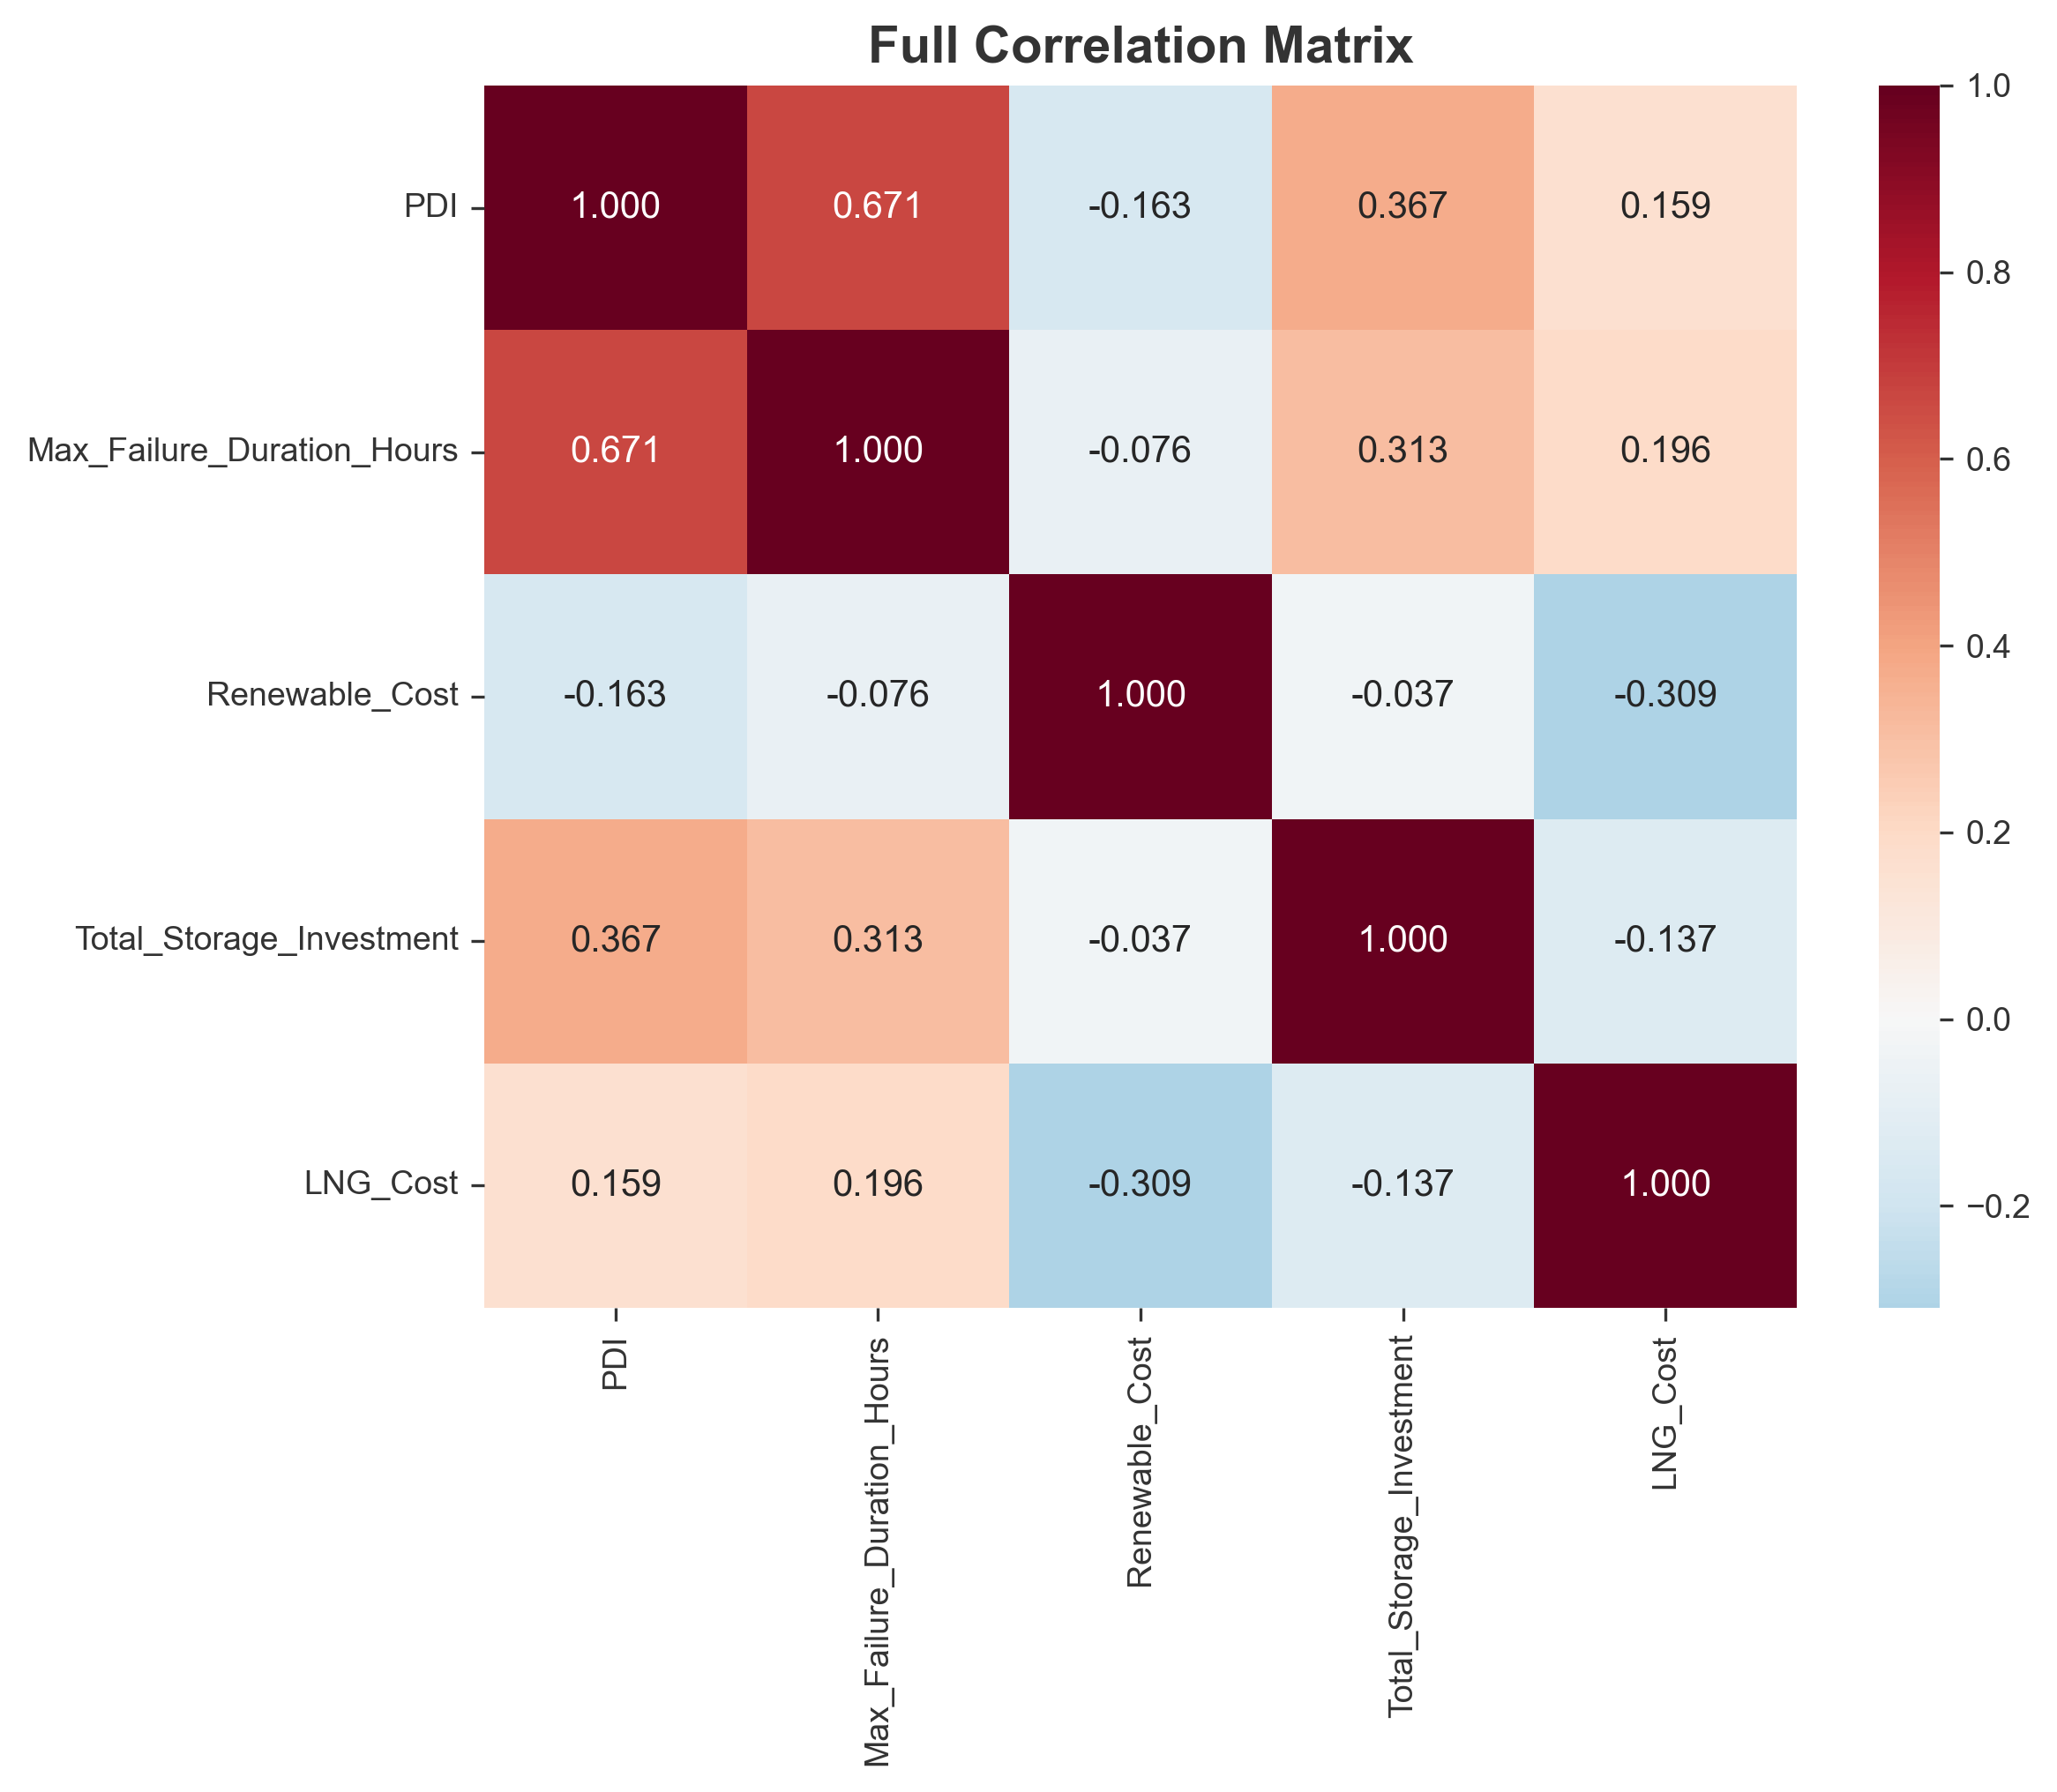


📊 Correlation Analysis Results:
  VIF Values (>5 suggests potential multicollinearity):
    ✅ PDI: 2.45
    ✅ Max_Failure_Duration_Hours: 2.45

📏 STAGE 2: LINEAR MODELING

📊 Analyzing Renewable Cost:
  • Test R²: 0.0161
  • Test RMSE: 141.70
  • CV R² (mean±std): -0.0217 ± 0.0281

📊 Analyzing Total Storage Investment:
  • Test R²: 0.1119
  • Test RMSE: 147.44
  • CV R² (mean±std): 0.0051 ± 0.0678

📊 Analyzing LNG Cost:
  • Test R²: 0.0419
  • Test RMSE: 173.76
  • CV R² (mean±std): -0.0086 ± 0.0496


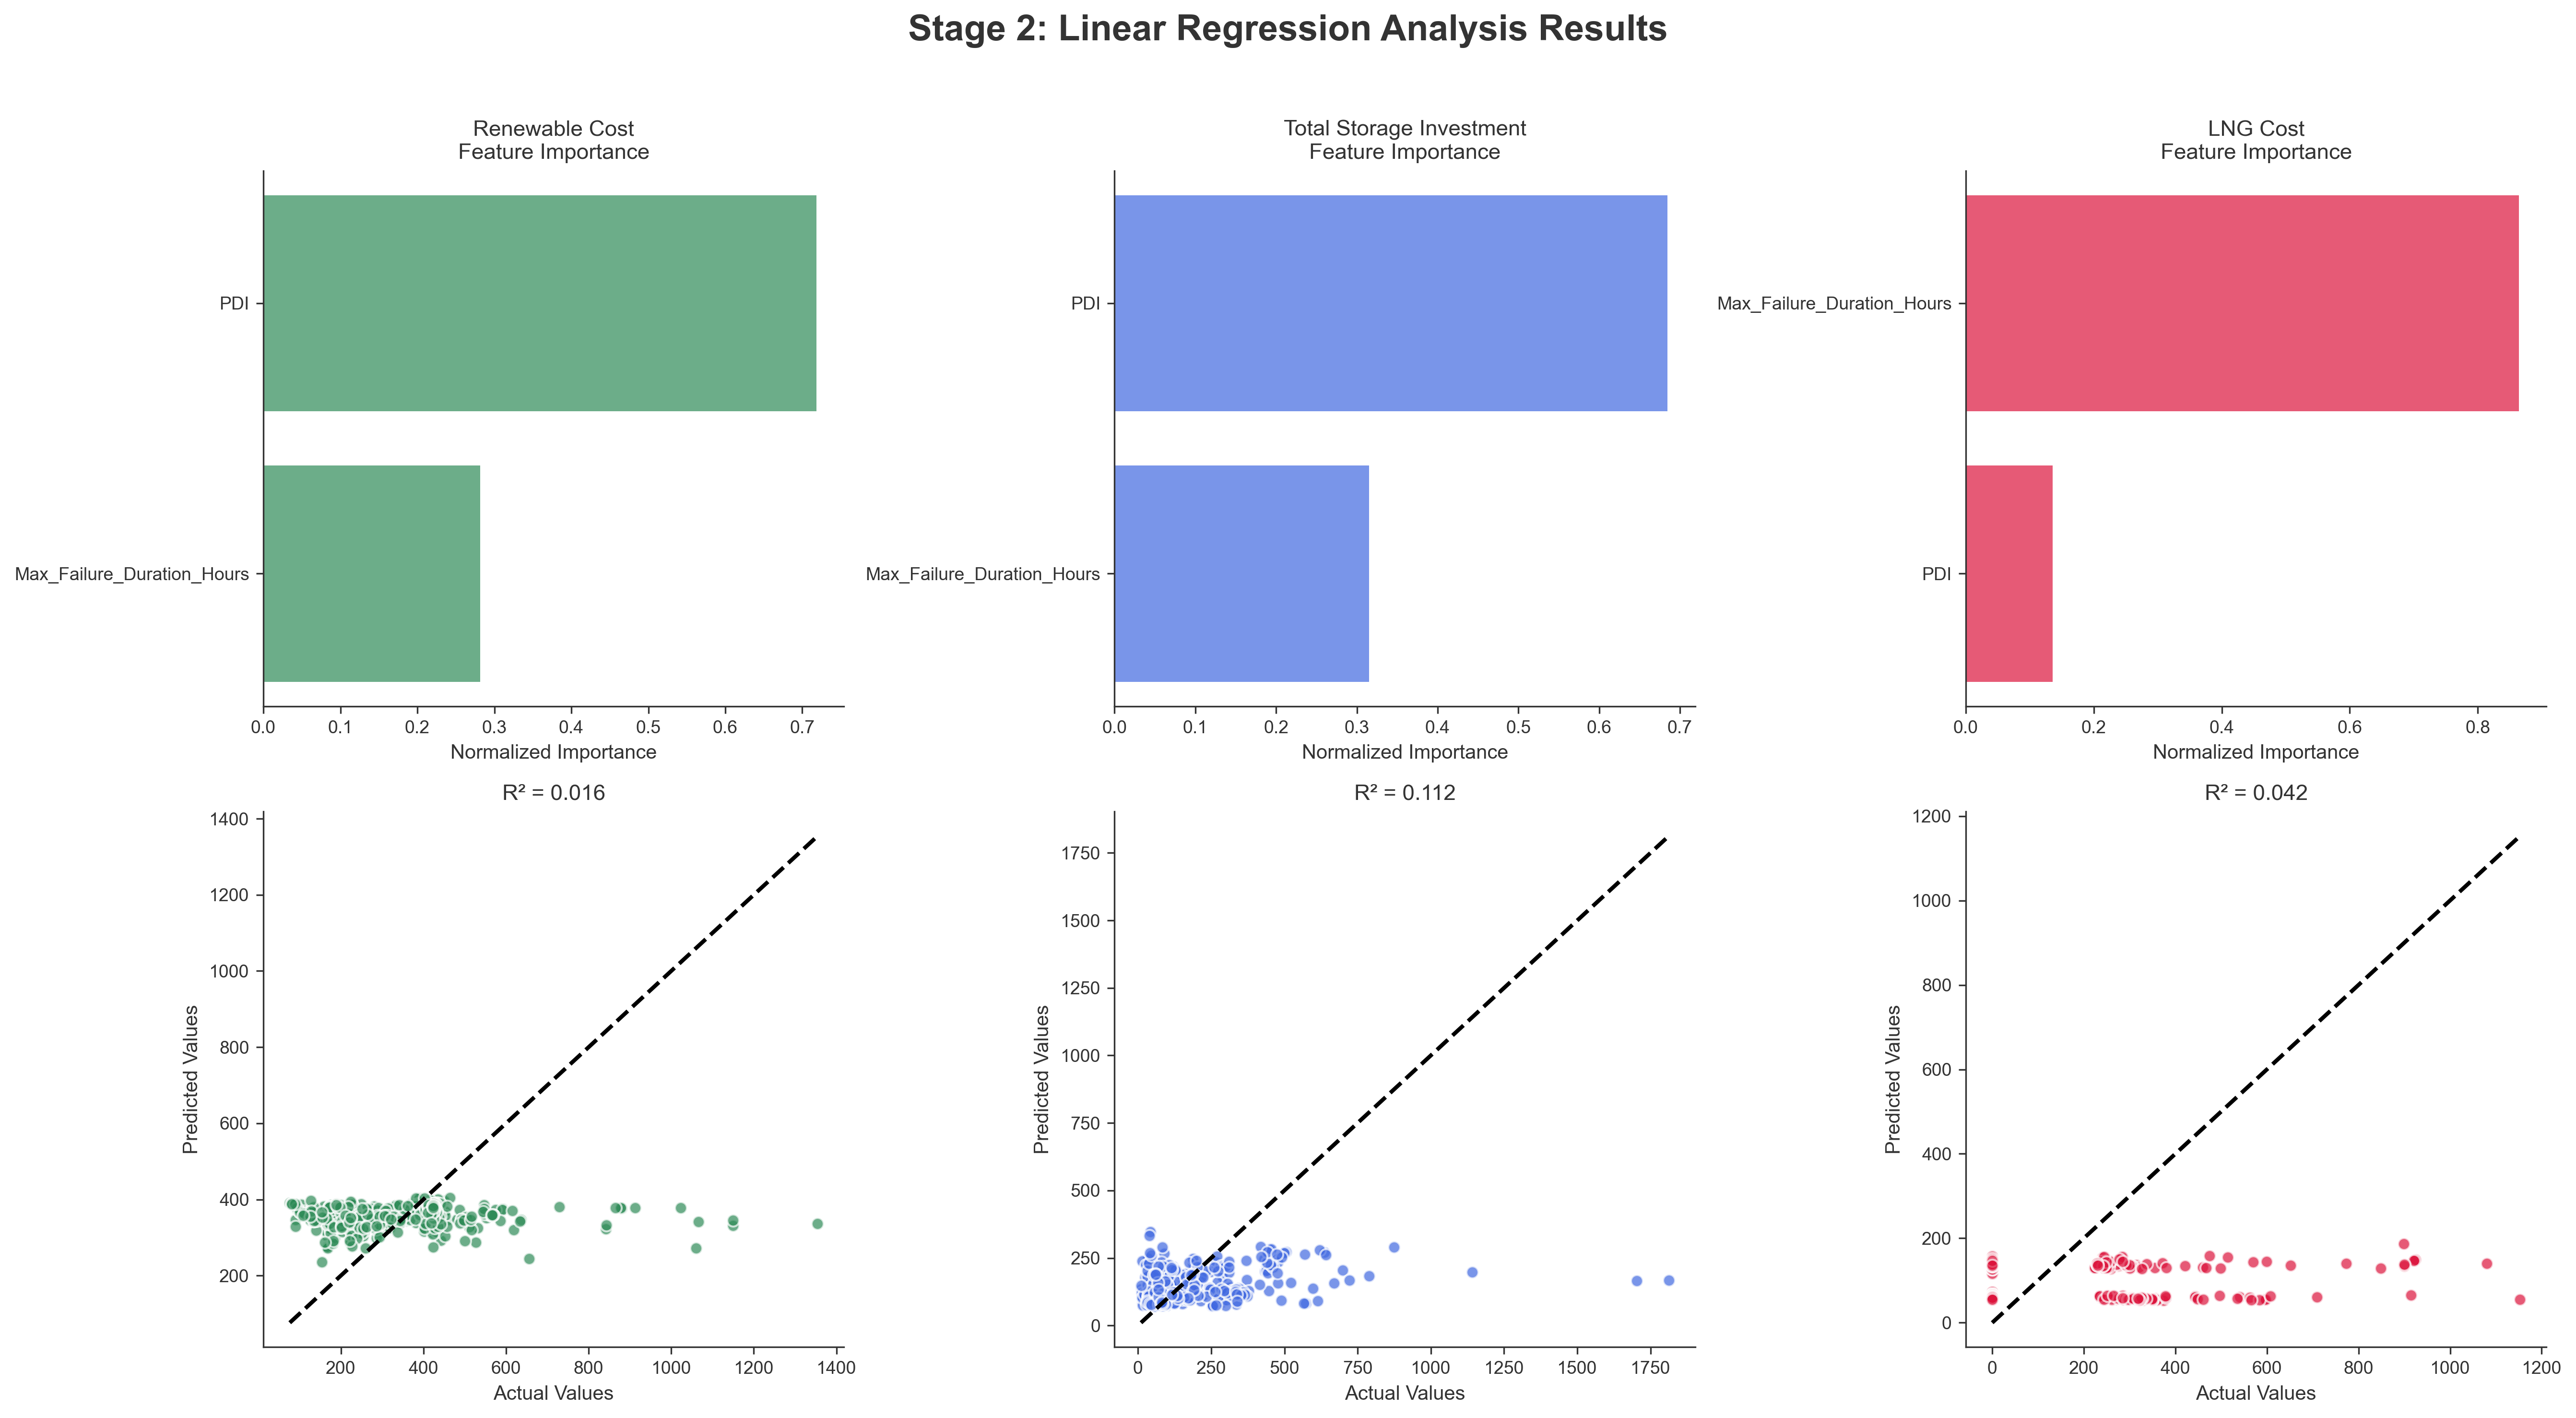


🔬 STAGE 3: LINEAR MODEL INTERPRETATION

🎯 Linear model interpretation for Renewable Cost:
  📈 Standardized Coefficients:
    Max_Failure_Duration_Hours    : 11.8751
    PDI                           : -30.2748


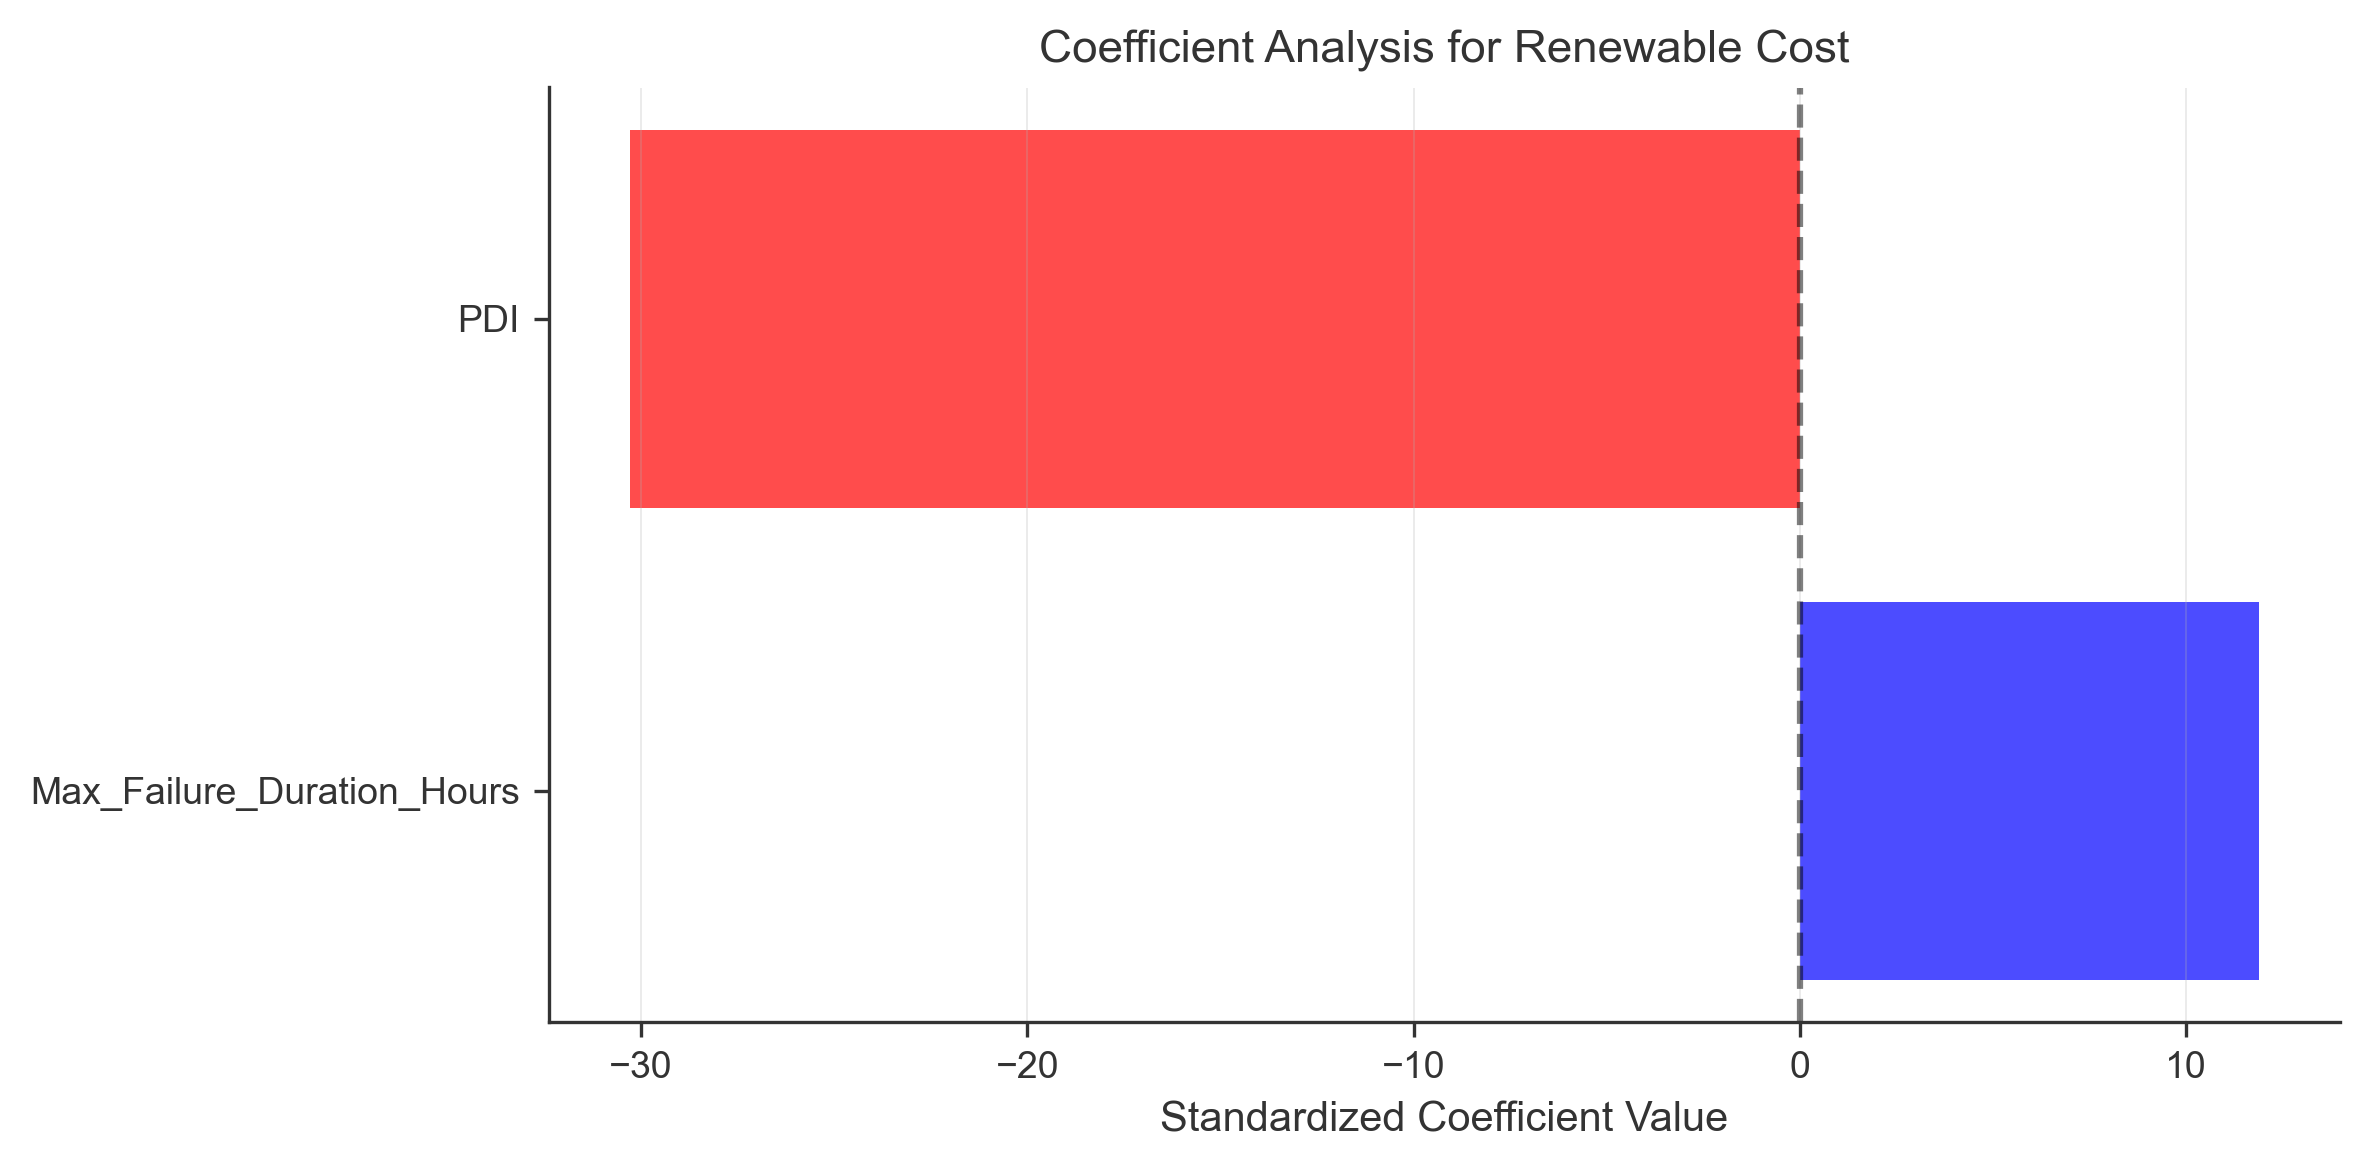


🎯 Linear model interpretation for Total Storage Investment:
  📈 Standardized Coefficients:
    PDI                           : 36.9345
    Max_Failure_Duration_Hours    : 17.0025


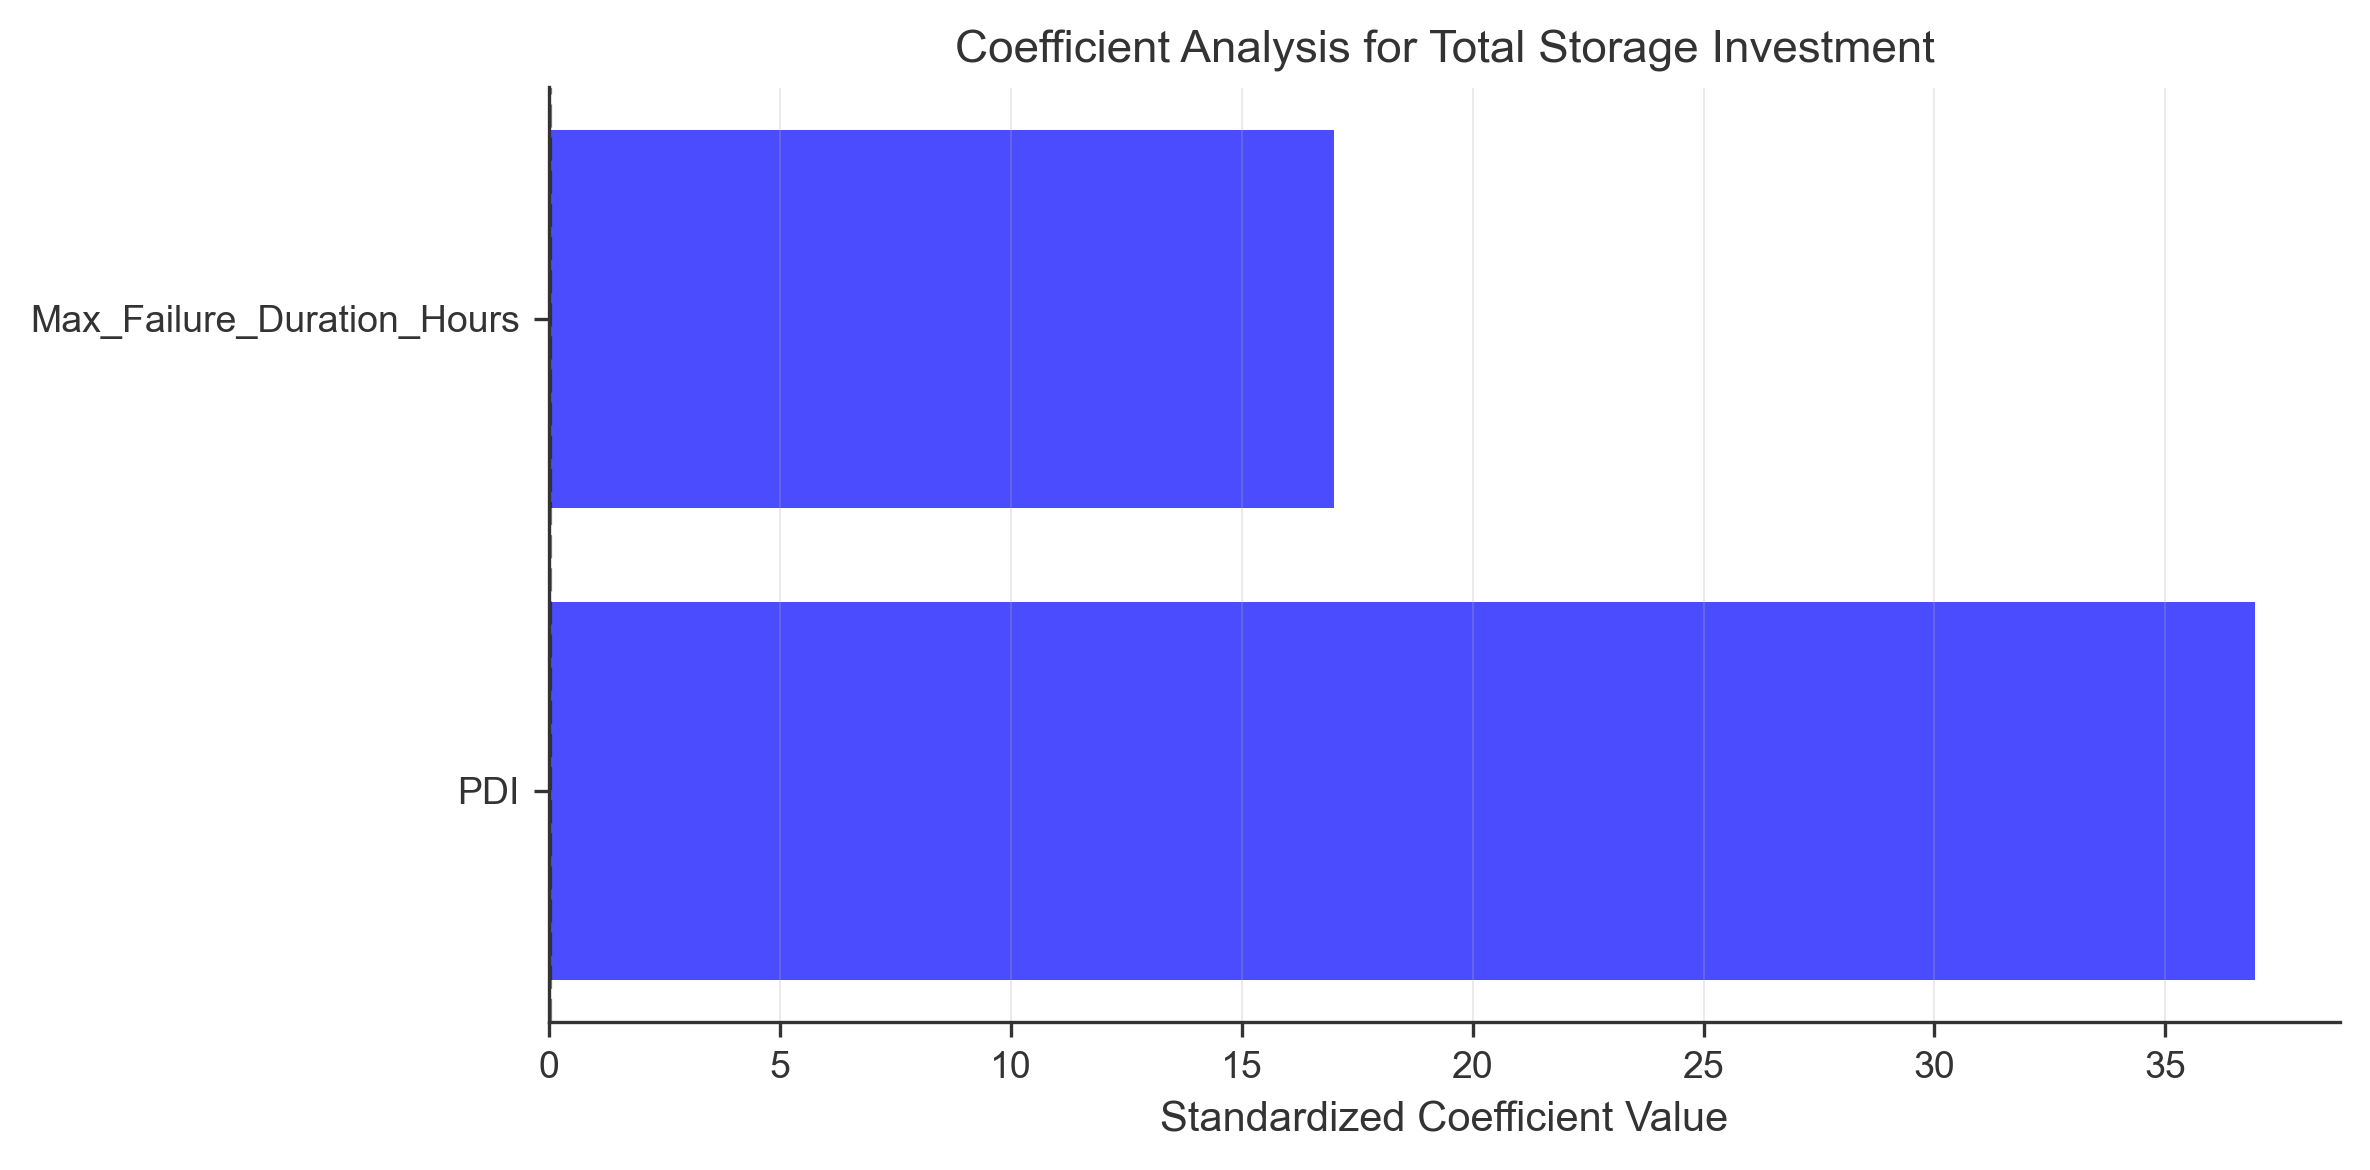


🎯 Linear model interpretation for LNG Cost:
  📈 Standardized Coefficients:
    Max_Failure_Duration_Hours    : 32.7033
    PDI                           : 5.1426


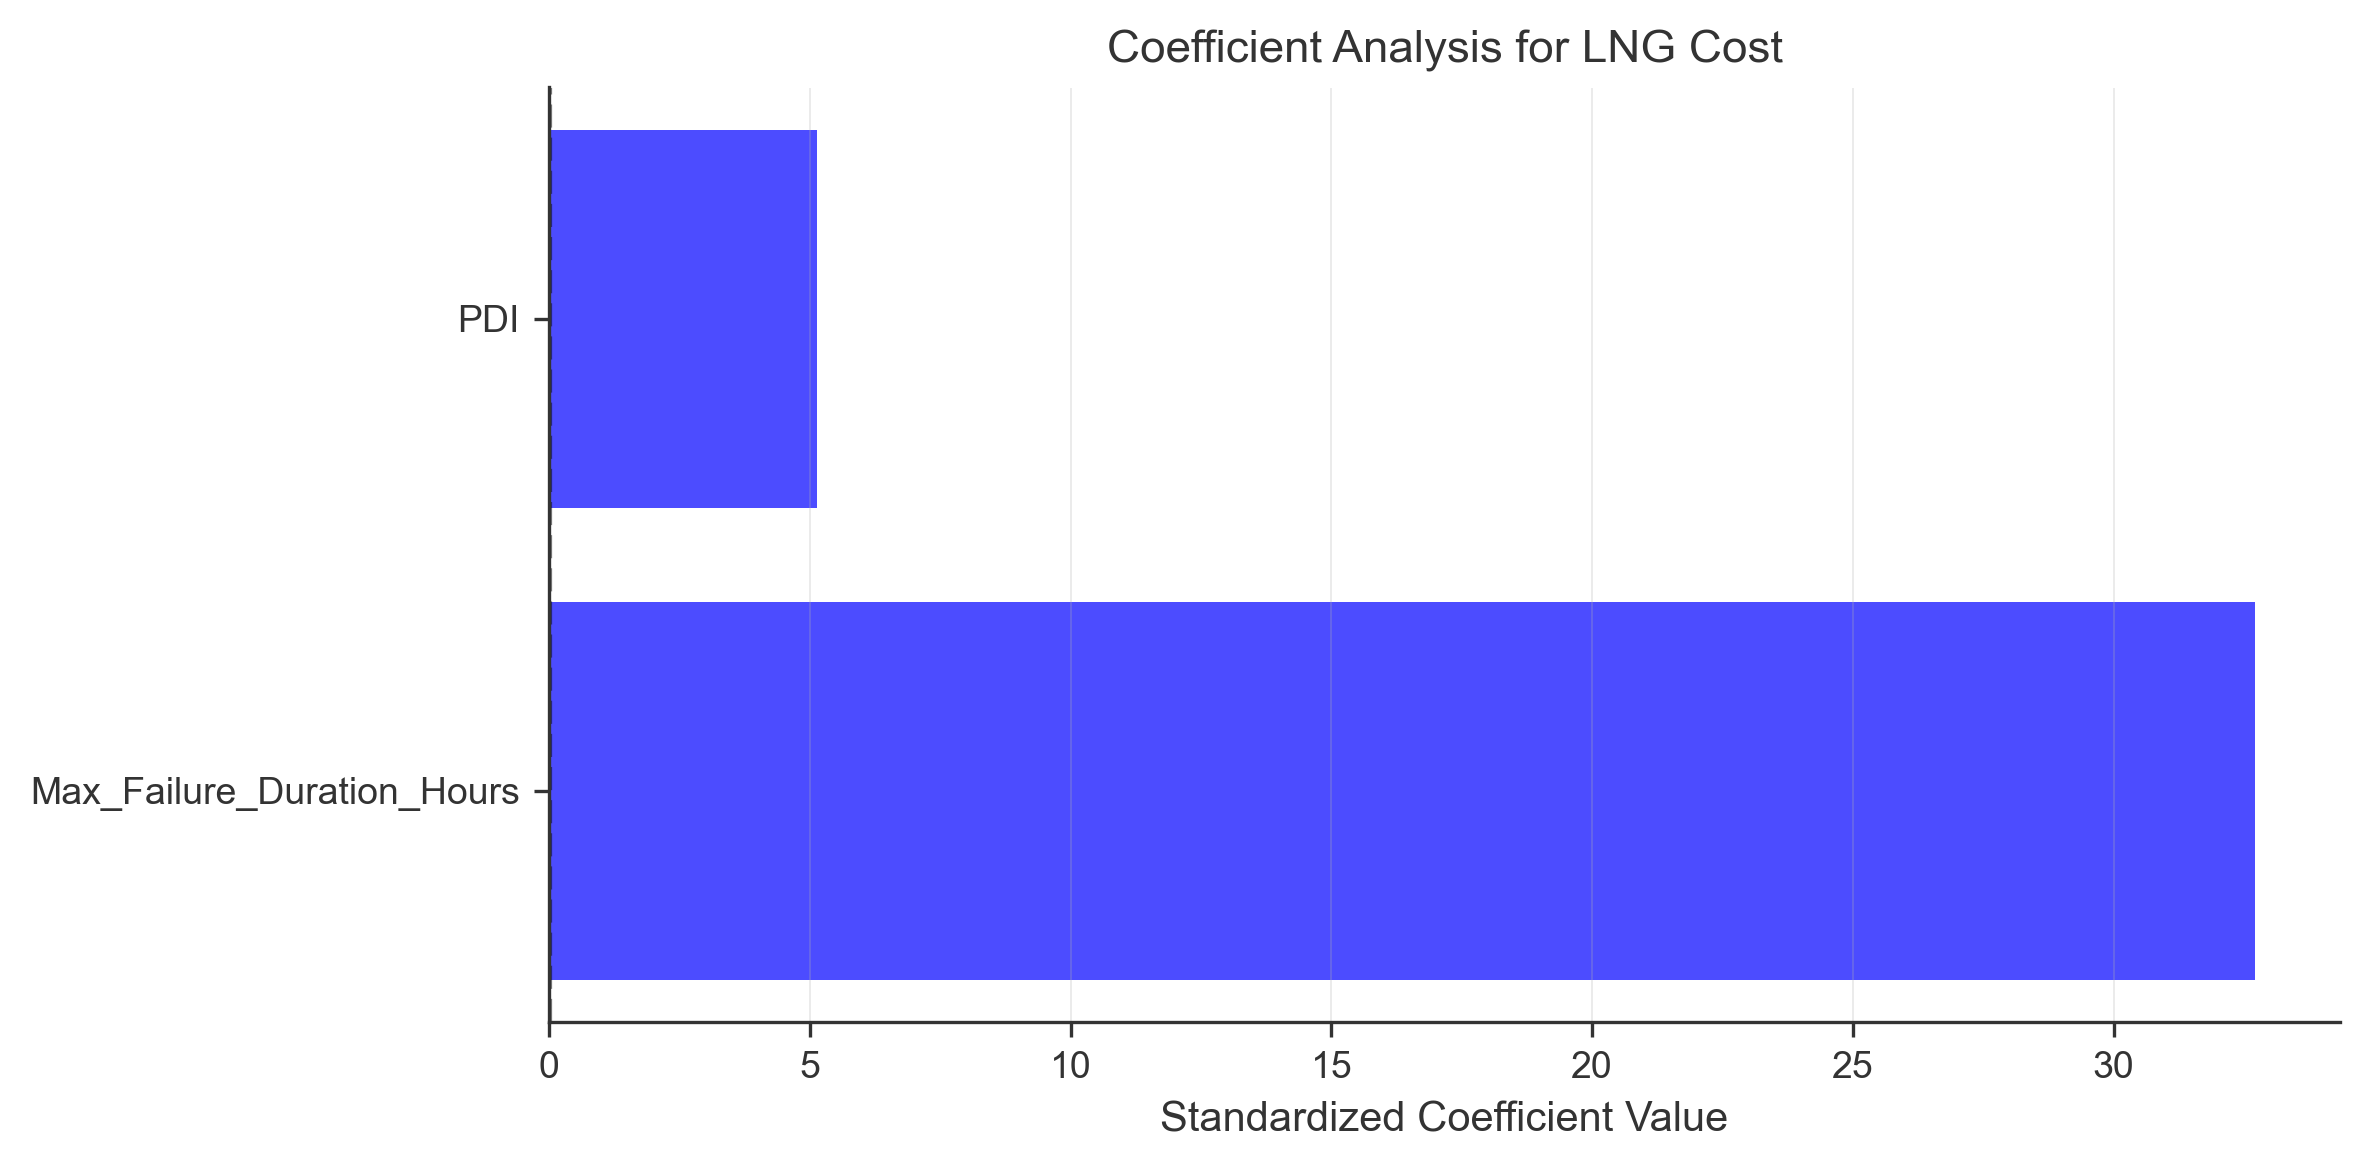

In [2]:

if __name__ == "__main__":
    import pickle
    
    analyzer = AdvancedEnergyAnalysis(random_state=42)
    
    print("Advanced Energy System Investment Analysis")
    print("Using streamlined progressive modeling approach:")
    print("  1. Correlation Analysis (Global View)")
    print("  2. Linear Modeling (Performance Evaluation)")
    print("  3. Deep Interpretation (Coefficient Analysis)")
    print("  4. Advanced Correlation (Sliding Window Analysis)\n")
    
    df = analyzer.calculate_real_data()
    if df is None:
        exit(1)
    
    df_cleaned = analyzer.apply_data_cleaning(strategy='moderate')
    if len(df_cleaned) < 30:
        print("❌ Insufficient data after cleaning. Halting analysis.")
        exit(1)
    
    try:
        # Execute streamlined analysis stages
        analyzer.stage1_correlation_analysis()
        analyzer.stage2_linear_modeling()
        analyzer.stage3_deep_interpretation()
          
    except Exception as e:
        print(f"\n❌ Analysis failed with error: {str(e)}")
        import traceback
        traceback.print_exc()


🧪 STAGE 4: ADVANCED CORRELATION ANALYSIS (SLIDING WINDOW)
renewable_min:0.4663976214281303, renewable_max:1


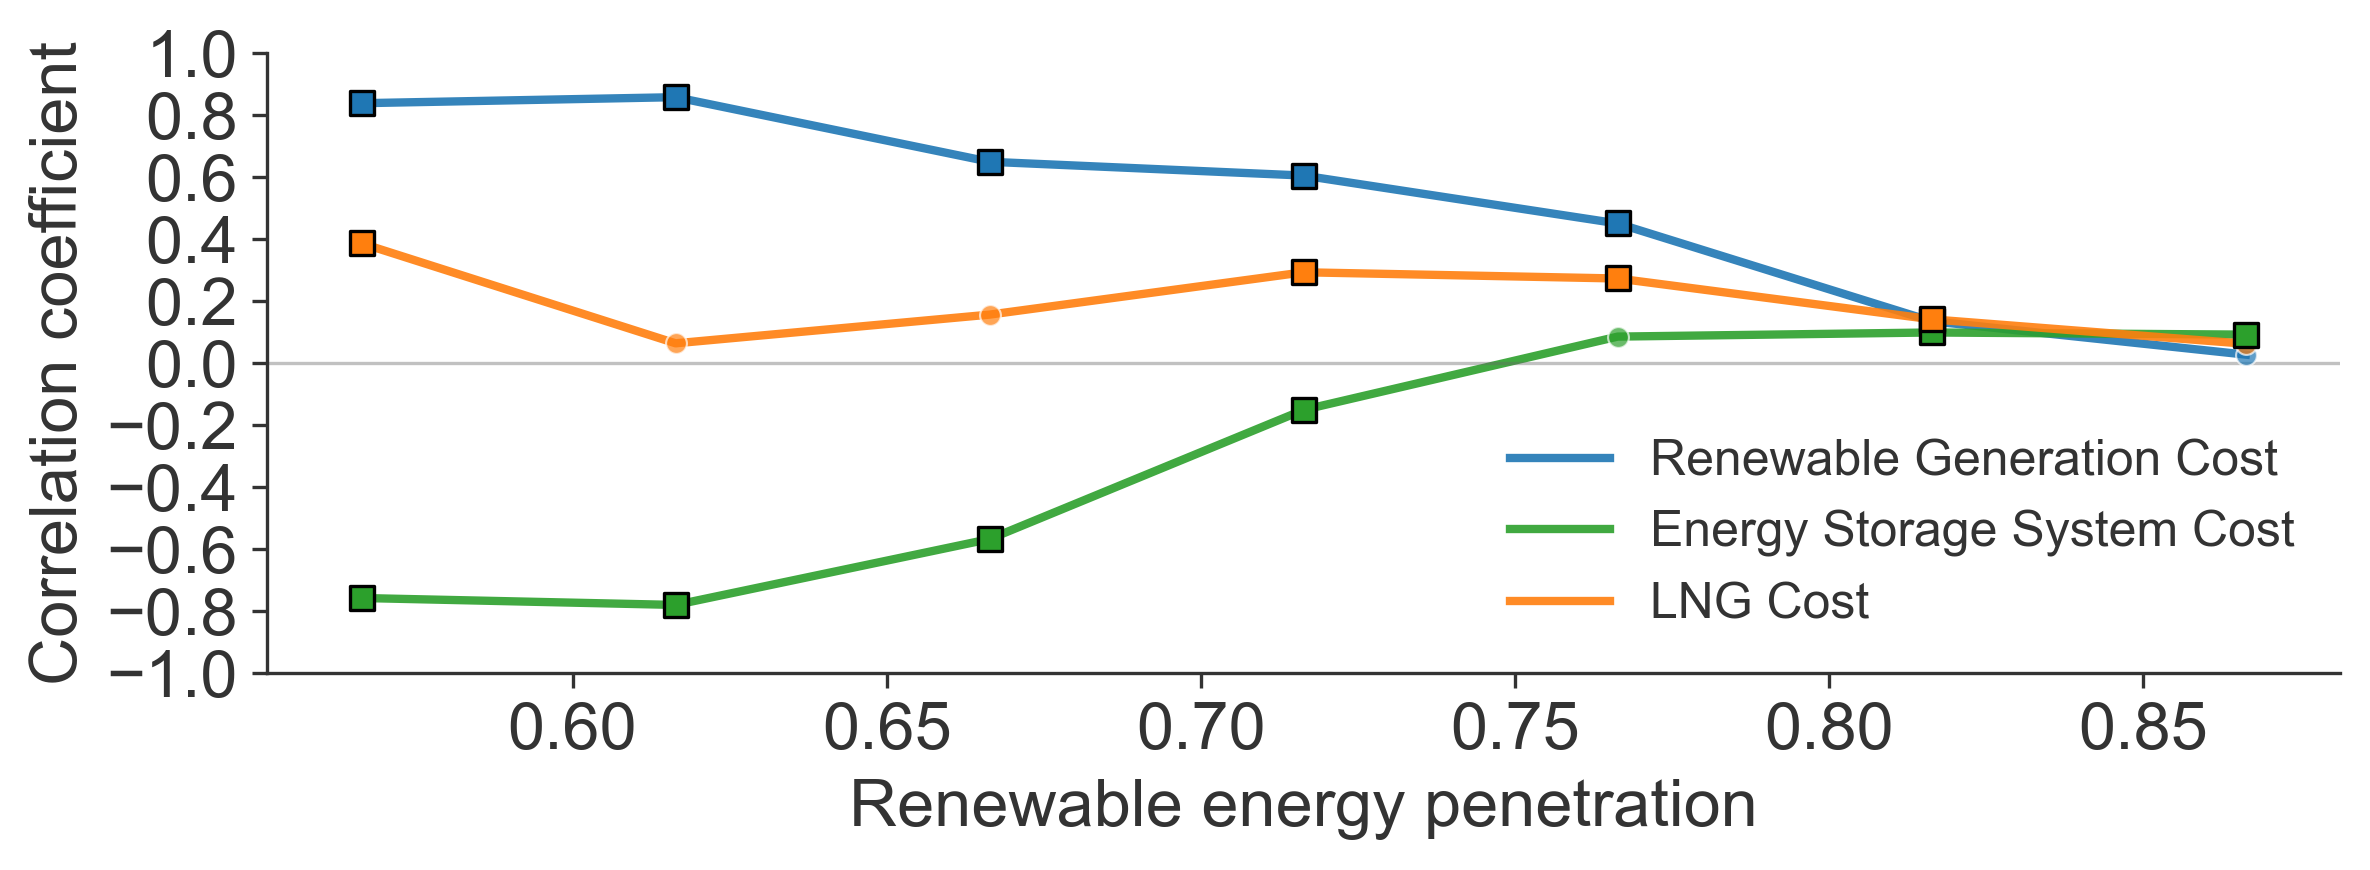


📋 COMPREHENSIVE ANALYSIS REPORT

🎯 SUMMARY OF FINDINGS:
----------------------------------------

📊 LINEAR REGRESSION PERFORMANCE (Test R²):
  • Renewable Cost           : R² = 0.0161
  • Total Storage Investment : R² = 0.1119
  • LNG Cost                 : R² = 0.0419

🔍 KEY FEATURE INSIGHTS (Normalized Importance):

  RENEWABLE COST:
    - PDI                           : 0.718
    - Max_Failure_Duration_Hours    : 0.282

  TOTAL STORAGE INVESTMENT:
    - PDI                           : 0.685
    - Max_Failure_Duration_Hours    : 0.315

  LNG COST:
    - Max_Failure_Duration_Hours    : 0.864
    - PDI                           : 0.136

📈 ADVANCED CORRELATION INSIGHTS:
  Sliding window analysis reveals how the correlation between disaster
  indicators and system costs changes across different levels of
  renewable energy penetration, highlighting complex interactions.

✅ COMPREHENSIVE ANALYSIS COMPLETED!


In [3]:
analyzer.stage4_advanced_correlation_analysis()
analyzer.generate_comprehensive_report()